## Import Libraries

In [21]:
# import stopwords from nltk
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split

# import tensorflow and various layers for neural network
import tensorflow as tf
from tensorflow.keras.layers import Embedding,SimpleRNN, Dense,GRU,LSTM,Bidirectional,Dropout,BatchNormalization

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np

# import to extract zip file
import zipfile
# import the 'os' module for interacting with the operating system
import os
# import for downloading files directly from Google Drive
import gdown

# import requests to make HTTP requests
import requests
# import regular expression for text processing
import re

import string
import nltk
import torch

## Data Downloading

#### Upload the ZIP file to Google Drive, then download it using the provided URL, extract the ZIP file, and load the data

In [33]:
# extract file ID from the Google Drive link
def download_and_extract_zip(drive_link, save_path="dataset.zip", extract_to="dataset"):
    try:
        file_id = drive_link.split("/d/")[1].split("/")[0]
    except IndexError:
        print("Invalid Google Drive link format.")
        return
        
    # construct the direct download URL using the extracted file ID
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # download the file using gdown
    print("Downloading file...")
    gdown.download(download_url, save_path, quiet=False)

    # extract the ZIP file
    if os.path.exists(save_path):
        print("Extracting files...")
        with zipfile.ZipFile(save_path, "r") as zip_ref:
            zip_ref.extractall(extract_to)
        print("Extraction complete")
    else:
        print("Download failed")

In [40]:
def load_data(file_path):
    # load dataset as a Pandas DataFrame
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        print("Dataset Loaded Successfully.")
        # check first few rows 
        print(df.head())  
        return df
    else:
        print(f"File {file_path} not found.")
        return None


In [41]:
# get Google Drive link, extract and take the dataset
drive_link = "https://drive.google.com/file/d/1ZhYQb0pm7fOLeNVdYqCxHIeXTt5tMS11/view?usp=sharing"
download_and_extract_zip(drive_link)

# file name
dataset_path = "dataset/IMDB Dataset.csv"
# load the dataset
train_data = load_data(dataset_path)

Downloading...
From (original): https://drive.google.com/uc?id=1ZhYQb0pm7fOLeNVdYqCxHIeXTt5tMS11
From (redirected): https://drive.google.com/uc?id=1ZhYQb0pm7fOLeNVdYqCxHIeXTt5tMS11&confirm=t&uuid=7e9d72ae-e778-4b6b-b8d5-e8f3deed5dab
To: /kaggle/working/dataset.zip
100%|██████████| 27.0M/27.0M [00:00<00:00, 249MB/s]


Extracting files...
Extraction complete.
Dataset Loaded Successfully.
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [60]:
# check format and check the length
train_data
train_data.shape

(50000, 2)

In [62]:
# split train and test set ((the last 10% of rows serve as the test set)

# calculate the index for the last 10% of rows
test_size = int(0.1 * len(train_data))

# split the dataset such that the last 10% of rows are used for the test set
df_test = train_data[-test_size:]  # take the last 10% of the rows
df_train = train_data[:-test_size]  # take the remaining 90% as the training set

# print shapes to verify
print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

Training set shape: (45000, 2)
Test set shape: (5000, 2)


In [80]:
# train test split
train_df, test_df = train_test_split(df_train, test_size=0.2, random_state=42)

In [81]:
# print shapes to verify
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (36000, 2)
Test set shape: (9000, 2)


## Data Preprocessing

In [82]:
# download stopwords
nltk.download("stopwords")

# define stopwords
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
def preprocess_text(text):
    # convert all characters in the text to lowercase
    text = text.lower()
    # remove all digits from the text using a regular expression
    text = re.sub(r"\d+", "", text)
    # remove all punctuation from the text
    text = text.translate(str.maketrans("", "", string.punctuation))
    # remove stopword 
    text = " ".join([word for word in text.split() if word not in stop_words])
    # deal with spaces
    text = re.sub(r"\s+", " ", text).strip()

    # return preprocessed text
    return text

In [84]:
# apply preprocess function for train_df and test_df
train_df["review"] = train_df["review"].apply(preprocess_text)
test_df["review"] = test_df["review"].apply(preprocess_text)

In [85]:
# separate review (input text) and sentiment (target labels)
X_train = train_df["review"].values
y_train = train_df["sentiment"].values

X_test = test_df["review"].values
y_test = test_df["sentiment"].values

# check type and unique values
print("y_train type:", type(y_train))
print("Unique values in y_train:", np.unique(y_train))

y_train type: <class 'numpy.ndarray'>
Unique values in y_train: ['negative' 'positive']


In [87]:
# map 1 for positive, 0 for negative
if y_train.dtype == 'O':
    label_mapping = {'positive': 1, 'negative': 0}
    # mapping
    y_train = np.array([label_mapping[label] for label in y_train], dtype=np.float32)
    y_test = np.array([label_mapping[label] for label in y_test], dtype=np.float32)
else:
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

## Build Model

#### Build three models: Vanilla RNN, GRU, and LSTM) to predict whether a review is positive or negative.

In [88]:
# set hyperparameters for the text preprocessing and model
MAX_WORDS = 10000
MAX_LEN = 500
EMBEDDING_DIMS = 128

In [89]:
# initialize the Tokenizer object
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [90]:
# define early_stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#### Vanilla RNN Model

#### Define a simple Recurrent Neural Network (RNN) model using Keras. 
#### Model Architecture: Embedding Layer, SimpleRNN Layer, Dense Layer. The model used with Adam optimizer, loss function is Binary Crossentropy and track accuracy as the evaluation metric

In [91]:
# Vanilla RNN model
# Embedding Layer: size of vocab, dimensionality of word vectors, handle padding tokens
# SimpleRNN Layer: 128 units in the RNN, 0.2 dropout rate for input, 0.2 dropout rate for recurrent connections
# Dense Layer: use sigmoid function to output probabilities

def create_rnn_model():
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIMS, mask_zero=True),  # mask_zero=True
        SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False),  # return_sequences=False -> output 2D
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

#### GRU Model

#### Model Architecture using GRU:
#### Embedding Layer, Dropout Layer, GRU Layer (first and second), Dense Hidden Layer, Output Layer

In [105]:
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def create_gru_model():
    # convert text to dense vectors, handles padding (mask_zero=True)
    model = Sequential([
        Embedding(
            input_dim=MAX_WORDS,
            output_dim=EMBEDDING_DIMS,
            input_length=MAX_LEN,
            mask_zero=True
        ),

        # 30% dropout to reduce overfitting
        Dropout(0.3),

        # GRU Layers
        # First GRU: 128 units, dropout (0.3), recurrent dropout (0.2), L2 regularization
        GRU(
            128,
            return_sequences=True,
            dropout=0.3,
            recurrent_dropout=0.2,
            kernel_regularizer=l2(1e-4)
        ),
        # Second GRU: 64 units, dropout (0.2), recurrent dropout (0.1)
        GRU(
            64,
            dropout=0.2,
            recurrent_dropout=0.1
        ),
        
        # Hidden Layer with regularization
        # Dense Hidden Layer – 32 units, ReLU activation, L2 regularization
        Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        
        # 1 unit, sigmoid activation for output binary classification
        Dense(1, activation='sigmoid')
    ])
    # Optimizer: Adam with a learning rate of 1e-4
    # Loss Function: Binary Cross-Entropy
    # Evaluation Metric: accuracy
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model



#### LSTM Model

In [120]:
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def create_lstm_model():
    model = Sequential([
        # Embedding Layer with mask_zero and dropout
        Embedding(
            input_dim=MAX_WORDS,
            output_dim=64,
            input_length=MAX_LEN,
            mask_zero=True
        ),
        Dropout(0.3),  # add dropout for embedding
        
        # Stacked LSTM Layers
        LSTM(
            64,  # 64 units
            return_sequences=True,
            dropout=0.3,
            recurrent_dropout=0.2
        ),
        
        LSTM(
            32,
            dropout=0.2,
            recurrent_dropout=0.1
        ),
        
        # Hidden Layer with regularization
        Dense(32, activation='relu'),
        Dropout(0.3),  # increase dropout instead BatchNorm
        
        # Output Layer
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

## Train Model

### Train Vanilla RNN Model

#### Prepare Data

In [71]:
# convert text data to sequences of integers using the tokenizer
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# padding sequence
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")


In [95]:
# train Vanilla RNN model
rnn_model = create_rnn_model()
X_train_tensor = np.array(X_train_pad, dtype=np.int32)
y_train_tensor = np.array(y_train, dtype=np.float32)
X_test_tensor = np.array(X_test_pad, dtype=np.int32)
y_test_tensor = np.array(y_test, dtype=np.float32)

# train model
history_rnn = rnn_model.fit(
    X_train_tensor, y_train_tensor,
    validation_data=(X_test_tensor, y_test_tensor),
    epochs=10, batch_size=64
)


Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.5185 - loss: 0.7025 - val_accuracy: 0.5917 - val_loss: 0.6700
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - accuracy: 0.6012 - loss: 0.6539 - val_accuracy: 0.6163 - val_loss: 0.6365
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - accuracy: 0.6617 - loss: 0.6072 - val_accuracy: 0.6514 - val_loss: 0.6071
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - accuracy: 0.7132 - loss: 0.5526 - val_accuracy: 0.6893 - val_loss: 0.5754
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - accuracy: 0.7406 - loss: 0.5152 - val_accuracy: 0.6877 - val_loss: 0.5953
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - accuracy: 0.7674 - loss: 0.4767 - val_accuracy: 0.7910 - val_loss: 0.4585
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - accuracy: 0.8138 - loss: 0.4150 - val_accuracy: 0.8082 - val_loss: 0.4370
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - accuracy: 0.8319 - loss: 0.3808 - 

### Train GRU Model

#### Prepare Data

In [106]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")


In [110]:
# train GRU model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
gru_model = create_gru_model()
history_gru = gru_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                            epochs=5, batch_size=128, callbacks=[early_stopping])

Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - accuracy: 0.5339 - loss: 0.7088 - val_accuracy: 0.7691 - val_loss: 0.5655
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 610s 2s/step - accuracy: 0.8213 - loss: 0.4338 - val_accuracy: 0.8166 - val_loss: 0.5014
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 609s 2s/step - accuracy: 0.8740 - loss: 0.3340 - val_accuracy: 0.8210 - val_loss: 0.4863
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - accuracy: 0.8835 - loss: 0.3097 - val_accuracy: 0.8271 - val_loss: 0.4571
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - accuracy: 0.8863 - loss: 0.4209 - val_accuracy: 0.8219 - val_loss: 0.4574


### Train LSTM Model

#### Prepare Data

In [118]:
# Define tokenizer (adjust num_words if needed)
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Fit tokenizer on training data

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

In [119]:
# Train LSTM model
lstm_model = create_lstm_model()
history_lstm = lstm_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                              epochs=5, batch_size=128, callbacks=[early_stopping])

Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.5561 - loss: 0.6819 - val_accuracy: 0.8272 - val_loss: 0.4440
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.8162 - loss: 0.4458 - val_accuracy: 0.8530 - val_loss: 0.3475
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - accuracy: 0.8587 - loss: 0.3611 - val_accuracy: 0.8653 - val_loss: 0.3218
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 553s 2s/step - accuracy: 0.8753 - loss: 0.3272 - val_accuracy: 0.8702 - val_loss: 0.3103
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 553s 2s/step - accuracy: 0.8856 - loss: 0.2998 - val_accuracy: 0.8762 - val_loss: 0.2992


### Plot results

In [77]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    # Plots training and validation accuracy over epochs
    
    if hasattr(history, 'history'): 
        history = history.history

    epochs = range(1, len(history['accuracy']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', marker='s')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

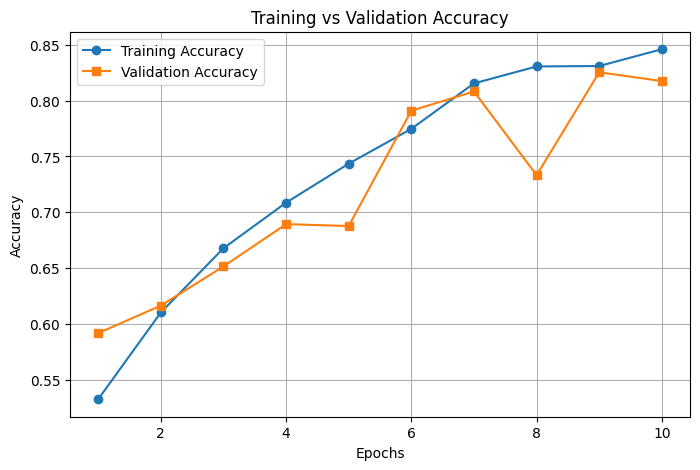

In [103]:
# plot rnn model
plot_accuracy(rnn_model.history)

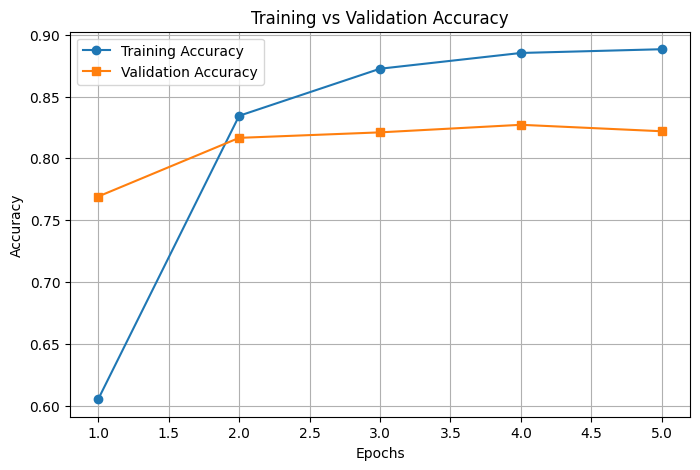

In [112]:
# plot gru model
plot_accuracy(gru_model.history)

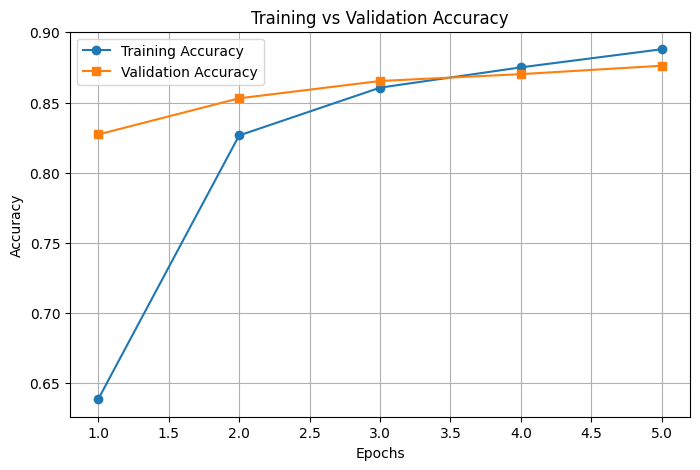

In [121]:
# plot lstm model
plot_accuracy(lstm_model.history)

### Comparison

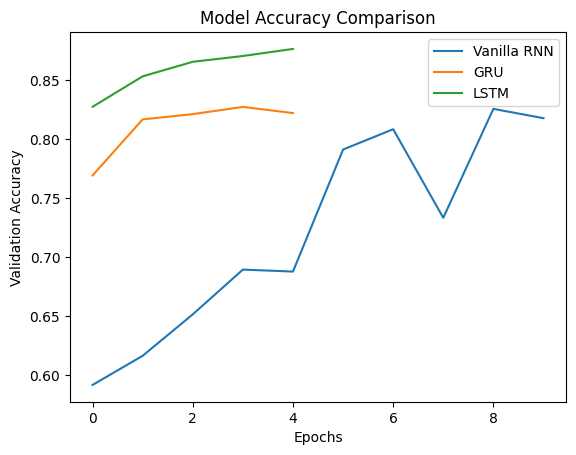

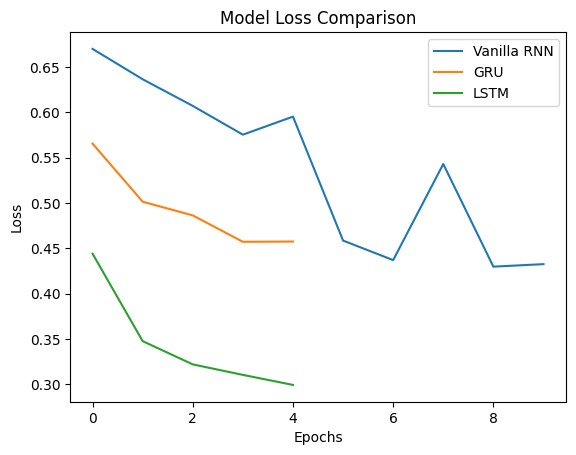

In [122]:
# print val-accuracy of 3 models for comparison
import matplotlib.pyplot as plt

# Plot val-accuracy
plt.plot(history_rnn.history['val_accuracy'], label="Vanilla RNN")
plt.plot(history_gru.history['val_accuracy'], label="GRU")
plt.plot(history_lstm.history['val_accuracy'], label="LSTM")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title("Model Accuracy Comparison")
plt.show()

# Plot val-loss
plt.plot(history_rnn.history['val_loss'], label='Vanilla RNN')
plt.plot(history_gru.history['val_loss'], label='GRU')
plt.plot(history_lstm.history['val_loss'], label='LSTM')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### **1. Validation Accuracy Comparison**
- **LSTM** achieves the highest validation accuracy, reaching above **0.87** after just a few epochs.
- **GRU** follows closely, maintaining an accuracy slightly above **0.82**.
- **Vanilla RNN** lags behind, starting at around **0.60** and gradually improving to slightly above **0.80**, but with fluctuations through some epochs.

#### **2. Loss Comparison**
- **LSTM** shows the best loss reduction, starting at around **0.44** and dropping below **0.3** in just a few epochs.
- **GRU** starts with a loss of around **0.56** and gradually decreases to about **0.45**.
- **Vanilla RNN** starts with the highest loss (above **0.67**) and fluctuates while decreasing but remains higher than GRU and LSTM.

#### Conclusion
- LSTM performs the best, achieving the highest accuracy and lowest loss.
- GRU is also strong, slightly behind LSTM but significantly better than Vanilla RNN.
- Vanilla RNN is the weakest in both accuracy and loss, showing slower convergence and more fluctuations.
